In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
from utils.plot import plot_map

/home/ltchen/gnnpp


In [2]:
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures/results/gnnexplainer_multirun')
os.makedirs(FIGUREPATH, exist_ok=True)

/home/ltchen/gnnpp


In [41]:
leadtime = "72h"
graph_name = "g5"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name)
with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)

g1_train_loader = DataLoader(g_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(g_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(g_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(g_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = g_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = g_train_rf[0].num_edge_features
num_nodes = g_train_rf[0].num_nodes

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g5_72h/params.json
[INFO] Loading precomputed graph data on g5...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.


In [42]:
d = "test_rf"
TRAINNAME = f"{graph_name}_{leadtime}_train_run0"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
multigraph = load_gnn_model(CKPT_PATH, num_nodes, emb_dim, edge_dim, in_channels, config)

if d == "train":
    graph_to_explain = g_train_rf[0]
if d == "test_rf":
    graph_to_explain = g_test_rf[0]
if d == "test_f":
    graph_to_explain = g_test_f[0]

multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
node_idx = 5 # 23 #5: g1: lr=0.04, es=0.01; g5: lr=0.04, edge_size=0.2, g4: 1000 epochs: lr=0.01, edge_size=0.005
degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")

Node 5 has 23.0 neighbors


In [23]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# seed = 42

## Multiple runs

In [39]:
df = pd.DataFrame(columns=['run_id', 'node', 'feature', 'weight'])
weights_dict = {}
num_runs = 5

for run_id in range(num_runs):
    set_seed(42*run_id)
    mexplainer = create_explainer(multigraph, epochs=1000, lr=0.04, edge_size = 0.2)
    explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                             edge_attr=graph_to_explain.edge_attr, index=node_idx)
    print(f'Generated explanations in {explanation.available_explanations}')

# Feature importance ################################################################
    feature_loc = torch.nonzero(explanation.node_mask,
                                as_tuple=False)  # feature_loc.shape = 384 (64*6), 2 (node, feature)
    # feature_tuples = [tuple(row.tolist()) for row in feature_loc]
    node_weights = explanation.node_mask[explanation.node_mask != 0]

    # print(node_weights.shape)
    if run_id == 0:
        df = pd.DataFrame({
            'node': feature_loc[:, 0].numpy(),
            'feature': feature_loc[:, 1].numpy(),
            f'weight_{run_id}': node_weights.numpy()
        })
    else:
        df[f'weight_{run_id}'] = node_weights.numpy()
    # df = pd.concat([df, new_df], ignore_index=True) # would add a row, but we want columns

# Neighboring node importance (edge masks) ######################################################################
    mask_idx = np.where(explanation.edge_mask > 0)[0]
    edge_weights = explanation.edge_mask[mask_idx]
    edge_idx = explanation.edge_index[:, mask_idx].squeeze(1)
    transposed = edge_idx.transpose(0, 1)

    #print(transposed.shape)
    tuples = [tuple(row.tolist()) for row in transposed]

    for i in range(len(tuples)):
        weight = edge_weights[i].item()
        key = tuples[i]
        if key in weights_dict:
            weights_dict[key].append(weight)
        else:
            weights_dict[key] = [weight]
    # print(weights_dict)
mean_edge_weights = {edge: sum(weights)/len(weights) for edge, weights in weights_dict.items()}
df['mean']= df[['weight_0', 'weight_1', 'weight_2', 'weight_3', 'weight_4']].mean(axis=1)
print(mean_edge_weights)
print(tuples)
print(df)

Generated explanations in ['node_mask', 'edge_mask']
Generated explanations in ['node_mask', 'edge_mask']
Generated explanations in ['node_mask', 'edge_mask']
Generated explanations in ['node_mask', 'edge_mask']
Generated explanations in ['node_mask', 'edge_mask']
{(6, 5): 0.9936042070388794, (10, 5): 0.9898128390312195}
[(6, 5), (10, 5)]
     node  feature  weight_0  weight_1  weight_2  weight_3  weight_4      mean
0       5        1  0.060515  0.022909  0.368665  0.019789  0.271852  0.148746
1       5        2  0.099754  0.033882  0.454333  0.028832  0.449817  0.213323
2       5        3  0.012406  0.008999  0.059713  0.008725  0.091629  0.036294
3       5        4  0.018337  0.012333  0.241860  0.011087  0.212061  0.099136
4       5        5  0.012317  0.010360  0.013175  0.010520  0.010503  0.011375
..    ...      ...       ...       ...       ...       ...       ...       ...
187    10       60  0.032170  0.020389  0.101799  0.019881  0.079619  0.050772
188    10       61  0.04708

0        0        1  0.009973  0.007603  0.005064  0.009434  0.007536
1        0        2  0.056476  0.029279  0.034645  0.038496  0.035135
2        0        3  0.058316  0.036242  0.055724  0.035053  0.032012
3        0        4  0.017180  0.006707  0.009130  0.007346  0.013454

In [65]:
feature_names, grouped = get_feature_list()
mode = 'single'
i = 49
if mode == 'single':
    if i == node_idx:
        TITLE = f"Feature importance of node {i}\n"
    else:
        TITLE = f"Feature importance of node {i} \nin neighborhood of node {node_idx}"
    sort_i = df[df['node']==i]
    # sort_i['weight'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='mean', ascending=False)
elif mode == 'all':
    sort_i = df.groupby('feature').mean()
    # print(sort_i)
    # sort_i['weight'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='mean', ascending=False)
    TITLE = f"Feature importance of all nodes \nin neighborhood of node {node_idx}"
else:
    print("Not a valid input.")

sort_i = sort_i.reset_index()
sort_i['feature_name'] = sort_i['feature'].apply(lambda i: feature_names[i])
sort_i

,index,node,feature,weight_0,weight_1,weight_2,weight_3,weight_4,mean,feature_name
0,12,49,13,0.000901,0.003136,0.001220,0.007248,0.002194,0.002940,t2m_mean
1,32,49,33,0.000841,0.003176,0.001033,0.005411,0.002171,0.002526,mn2t6_mean
2,34,49,35,0.000929,0.003272,0.001139,0.005135,0.002119,0.002519,mx2t6_mean
3,41,49,42,0.001368,0.003358,0.001281,0.002793,0.002153,0.002191,sshf6_std
4,8,49,9,0.000841,0.002566,0.001150,0.004314,0.001716,0.002117,stl1_mean
...,...,...,...,...,...,...,...,...,...,...
59,43,49,44,0.001022,0.000875,0.000991,0.001221,0.000912,0.001004,ssr6_std
60,9,49,10,0.001006,0.001042,0.001104,0.000972,0.000871,0.000999,stl1_std
61,51,49,52,0.001082,0.001039,0.001110,0.000878,0.000843,0.000990,tp6_std
62,60,49,61,0.001040,0.000944,0.001032,0.001019,0.000831,0.000973,t_mean


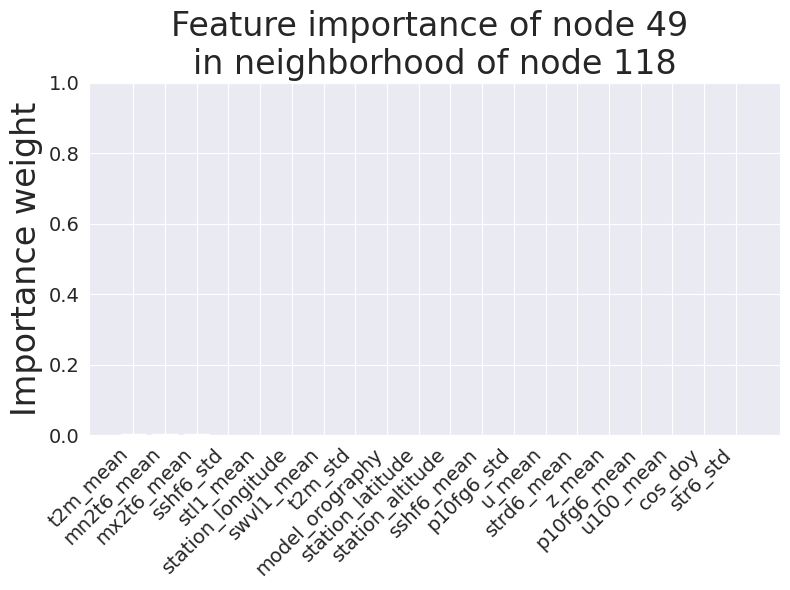

In [66]:
temperature_features = ['t2m_mean', 't2m_std', 'mn2t6_mean', 'mn2t6_std', 'mx2t6_mean', 'mx2t6_std']
alt_orog = ['station_altitude', 'model_orography']
# colors = ['orange' if feature in temperature_features else 'skyblue' for feature in sort_i['feature_name']]
colors = [
    'orange' if feature in temperature_features else
    'gray' if feature in alt_orog else
    'blue'
    for feature in sort_i['feature_name']
]
plt.figure(figsize=(8, 6))
plt.bar(sort_i['feature_name'][:20], sort_i['mean'][:20], color=colors)
# plt.bar(sort_i['feature_name'], sort_i['weight_mean'], color=colors)
# plt.xlabel('Feature', fontsize=24)
plt.ylabel('Importance weight', fontsize=24)
plt.ylim([0, 1])
plt.title(TITLE, fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, f"gnnx_features_{leadtime}_{node_idx}_{graph_name}_{d}_{mode}-{i}.pdf"), format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
dataframes = load_dataframes(leadtime)
dataframes = summary_statistics(dataframes)
dataframes['stations']

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


,station_id,lat,lon,altitude,orog,name
0,0,52.928000,4.781000,1.2,-1.706008,De Kooy
1,1,52.318000,4.790000,-3.3,-1.298122,Schiphol
2,2,53.241000,4.921000,10.8,0.333424,Vlieland
3,3,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling)
4,4,52.100000,5.180000,1.9,2.576800,De Bilt
...,...,...,...,...,...,...
115,115,45.786833,3.149333,331.0,521.714299,Clermont-Fd
116,116,47.499168,9.746111,424.0,689.253673,Bregenz
117,117,47.266666,9.600000,439.0,972.938723,Feldkirch
118,118,47.255833,10.186111,1478.0,1752.460782,Warth


In [27]:
# retrieve position from dataframes['stations']
pos_dict = {row['station_id']: (row['lon'], row['lat']) for _, row in dataframes['stations'].iterrows()}
alt_dict = {row['station_id']: row['altitude'] for _, row in dataframes['stations'].iterrows()}
node_list = df['node'].unique().tolist()
this_alt_dict = {node: alt_dict[node] for node in node_list if node in alt_dict}
lons = [pos_dict[node][0] for node in node_list if node in pos_dict]
lats = [pos_dict[node][1] for node in node_list if node in pos_dict]
this_alt_dict

{0: 1.2,
 2: 10.8,
 3: 0.7,
 4: 1.9,
 5: -1.3,
 6: -3.7,
 7: 1.2,
 8: -3.3,
 10: 2.9,
 11: 3.6,
 12: 15.8}

/home/ltchen/gnnpp/figures/results/gnnexplainer_multirun


<Figure size 600x800 with 0 Axes>

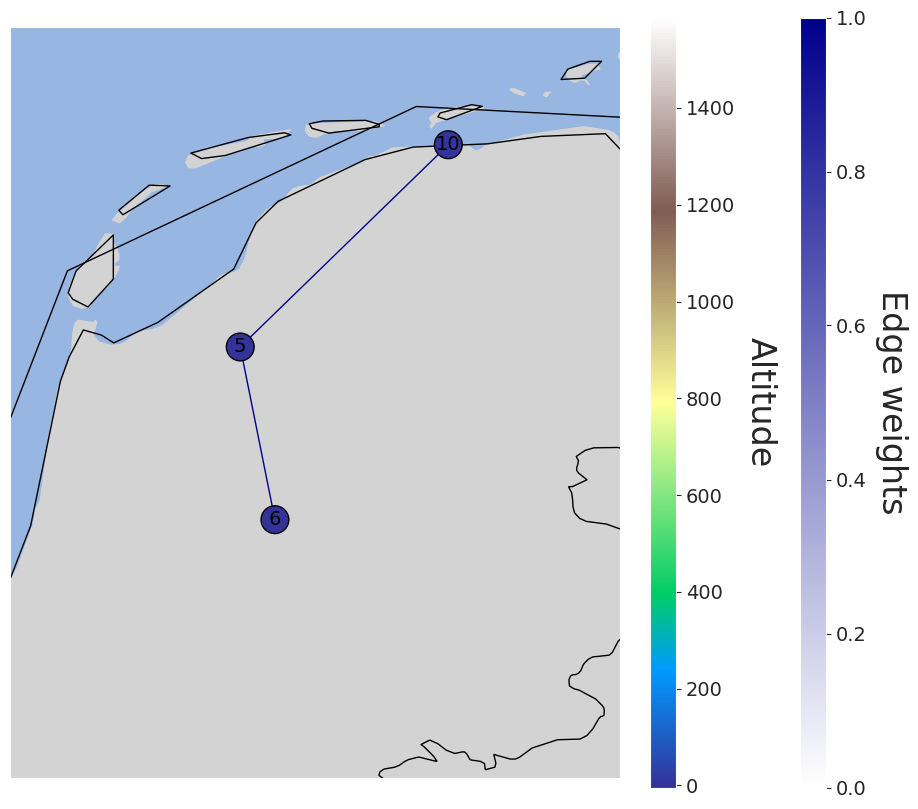

In [43]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import cartopy.crs as ccrs
subG = nx.Graph()

for (u, v), weight in zip (tuples, mean_edge_weights):
    subG.add_edge(u, v, weight=weight)

edges = list(mean_edge_weights.keys())
e_weights = list(mean_edge_weights.values())

fig = plt.figure(figsize=(6, 8))
ax = plot_map()

cmap_alt = cm.terrain
cmap_edge = LinearSegmentedColormap.from_list("white_to_blue", ["white", "darkblue"])

norm_edge = plt.Normalize(0, 1)
norm_alt = plt.Normalize(vmin=min(dataframes['stations']['altitude']), vmax=max(dataframes['stations']['altitude']))

edge_colors = [cmap_edge(norm_edge(w)) for w in e_weights]
node_colors = [cmap_alt(norm_alt(this_alt_dict[node])) for node in subG.nodes()]

proj = ccrs.PlateCarree()
margin = 0.3
lon_min, lon_max = min(lons) - margin, max(lons) + margin
lat_min, lat_max = min(lats) - margin, max(lats) + margin

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax.coastlines(resolution='110m')
# ax.set_extent([2, 8, 50, 54], crs=proj)

sm_nodes = plt.cm.ScalarMappable(cmap=cmap_alt, norm=norm_alt)
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
colbar2 = plt.colorbar(sm_edges, ax=ax, aspect=30, pad=0.04)
colbar1 = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.04)

colbar2.ax.set_ylabel("Edge weights", rotation=270, labelpad=30, fontsize=24)
colbar2.ax.tick_params(labelsize=14)
colbar1.ax.set_ylabel("Altitude", rotation=270, labelpad=30, fontsize=24)
colbar1.ax.tick_params(labelsize=14)

nx.draw_networkx(subG, pos_dict, node_size=400, node_color=node_colors, ax=ax, edge_color=edge_colors, edgecolors= 'black', with_labels=False)
nx.draw_networkx_labels(subG, pos_dict, font_size=14)
plt.savefig(os.path.join(FIGUREPATH, f"gnnx_map_{leadtime}_{node_idx}_{graph_name}_{d}.png"), format='png', dpi=300, bbox_inches='tight')
print(FIGUREPATH)

## One seed one run

In [2]:
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures/results/gnnexplainer_singlerun')
os.makedirs(FIGUREPATH, exist_ok=True)

/home/ltchen/gnnpp


In [10]:
df = pd.DataFrame(columns=['run_id', 'node', 'feature', 'weight'])
weights_dict = {}

mexplainer = create_explainer(multigraph, epochs=1000, lr=0.04, edge_size = 0.01) # lr= 0.04, edge_size = 0.03
set_seed(42)
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                             edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

# Feature importance ################################################################
feature_loc = torch.nonzero(explanation.node_mask,
                                as_tuple=False)  # feature_loc.shape = 384 (64*6), 2 (node, feature)
node_weights = explanation.node_mask[explanation.node_mask != 0]

df = pd.DataFrame({
    'node': feature_loc[:, 0].numpy(),
    'feature': feature_loc[:, 1].numpy(),
    f'weight': node_weights.numpy()
    })

# Neighboring node importance (edge masks) ##############################################
mask_idx = np.where(explanation.edge_mask > 0)[0]
edge_weights = explanation.edge_mask[mask_idx].tolist()
edge_idx = explanation.edge_index[:, mask_idx].squeeze(1)
transposed = edge_idx.transpose(0, 1)
#print(transposed.shape)
tuples = [tuple(row.tolist()) for row in transposed]

print(tuples)
print(edge_weights)

Generated explanations in ['edge_mask', 'node_mask']
[(49, 63), (63, 116), (63, 118), (63, 119), (116, 63), (116, 117), (116, 118), (117, 116), (117, 118), (118, 63), (118, 116), (118, 117), (118, 119), (119, 63), (119, 118)]
[0.9997925162315369, 0.9997881054878235, 0.999567449092865, 0.9997871518135071, 0.00023029714066069573, 0.0002329436392756179, 0.9997416138648987, 0.9997764229774475, 0.9992519021034241, 0.00023672846145927906, 0.9997885823249817, 0.9997875094413757, 0.9997926354408264, 0.00023857854830566794, 0.9996676445007324]


In [26]:
feature_names, grouped = get_feature_list()
mode = 'single'
i = 49
if mode == 'single':
    if i == node_idx:
        TITLE = f"Feature importance of node {i}\n"
    else:
        TITLE = f"Feature importance of node {i} \nin neighborhood of node {node_idx}"
    sort_i = df[df['node']==i]
    # sort_i['weight'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='weight', ascending=False)
elif mode == 'all':
    sort_i = df.groupby('feature').mean()
    # print(sort_i)
    # sort_i['weight'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='weight', ascending=False)
    TITLE = f"Feature importance of all nodes \nin neighborhood of node {node_idx}"
else:
    print("Not a valid input.")

sort_i = sort_i.reset_index()
sort_i['feature_name'] = sort_i['feature'].apply(lambda i: feature_names[i])
sort_i

,index,node,feature,weight,feature_name
0,12,49,13,0.001560,t2m_mean
1,32,49,33,0.001555,mn2t6_mean
2,34,49,35,0.001462,mx2t6_mean
3,27,49,28,0.001174,v100_std
4,6,49,7,0.001170,sd_mean
...,...,...,...,...,...
59,28,49,29,0.000969,vis_mean
60,40,49,41,0.000945,sshf6_mean
61,62,49,63,0.000938,cos_doy
62,35,49,36,0.000776,mx2t6_std


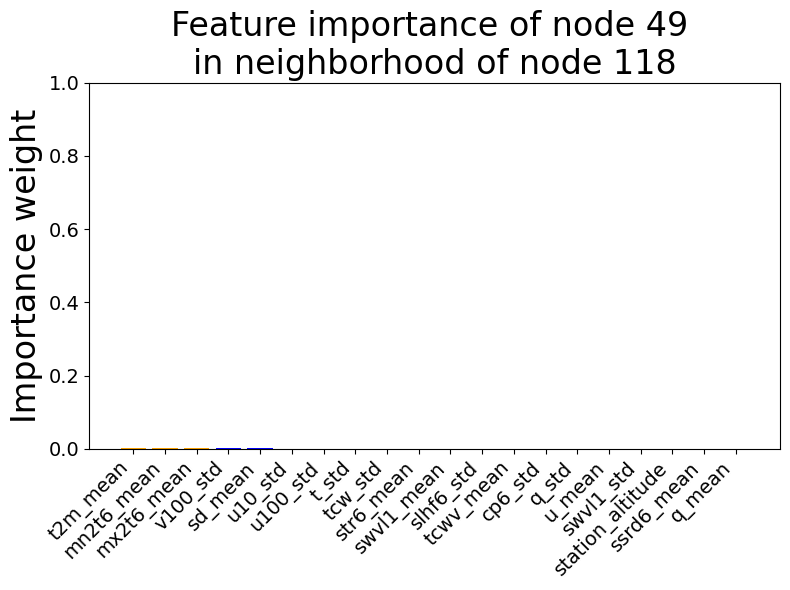

/home/ltchen/gnnpp/figures/results/gnnexplainer_singlerun


In [27]:
temperature_features = ['t2m_mean', 't2m_std', 'mn2t6_mean', 'mn2t6_std', 'mx2t6_mean', 'mx2t6_std']
alt_orog = ['station_altitude', 'model_orography']
# colors = ['orange' if feature in temperature_features else 'skyblue' for feature in sort_i['feature_name']]
colors = [
    'orange' if feature in temperature_features else
    'gray' if feature in alt_orog else
    'blue'
    for feature in sort_i['feature_name']
]
plt.figure(figsize=(8, 6))
plt.bar(sort_i['feature_name'][:20], sort_i['weight'][:20], color=colors)
# plt.bar(sort_i['feature_name'], sort_i['weight_mean'], color=colors)
# plt.xlabel('Feature', fontsize=24)
plt.ylabel('Importance weight', fontsize=24)
plt.ylim([0, 1])
plt.title(TITLE, fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, f"gnnx_features_{graph_name}_{mode}_{node_idx}-{i}_{leadtime}_{d}.pdf"), format='pdf', dpi=300, bbox_inches='tight')
plt.show()
print(FIGUREPATH)

In [249]:
dataframes = load_dataframes(leadtime)
dataframes = summary_statistics(dataframes)
dataframes['stations']

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


,station_id,lat,lon,altitude,orog,name
0,0,52.928000,4.781000,1.2,-1.706008,De Kooy
1,1,52.318000,4.790000,-3.3,-1.298122,Schiphol
2,2,53.241000,4.921000,10.8,0.333424,Vlieland
3,3,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling)
4,4,52.100000,5.180000,1.9,2.576800,De Bilt
...,...,...,...,...,...,...
115,115,45.786833,3.149333,331.0,521.714299,Clermont-Fd
116,116,47.499168,9.746111,424.0,689.253673,Bregenz
117,117,47.266666,9.600000,439.0,972.938723,Feldkirch
118,118,47.255833,10.186111,1478.0,1752.460782,Warth


In [250]:
# retrieve position from dataframes['stations']
pos_dict = {row['station_id']: (row['lon'], row['lat']) for _, row in dataframes['stations'].iterrows()}
alt_dict = {row['station_id']: row['altitude'] for _, row in dataframes['stations'].iterrows()}
node_list = df['node'].unique().tolist()
this_alt_dict = {node: alt_dict[node] for node in node_list if node in alt_dict}
lons = [pos_dict[node][0] for node in node_list if node in pos_dict]
lats = [pos_dict[node][1] for node in node_list if node in pos_dict]
lats
# this_alt_dict

[52.898, 52.458, 53.413]

<Figure size 1200x1200 with 0 Axes>

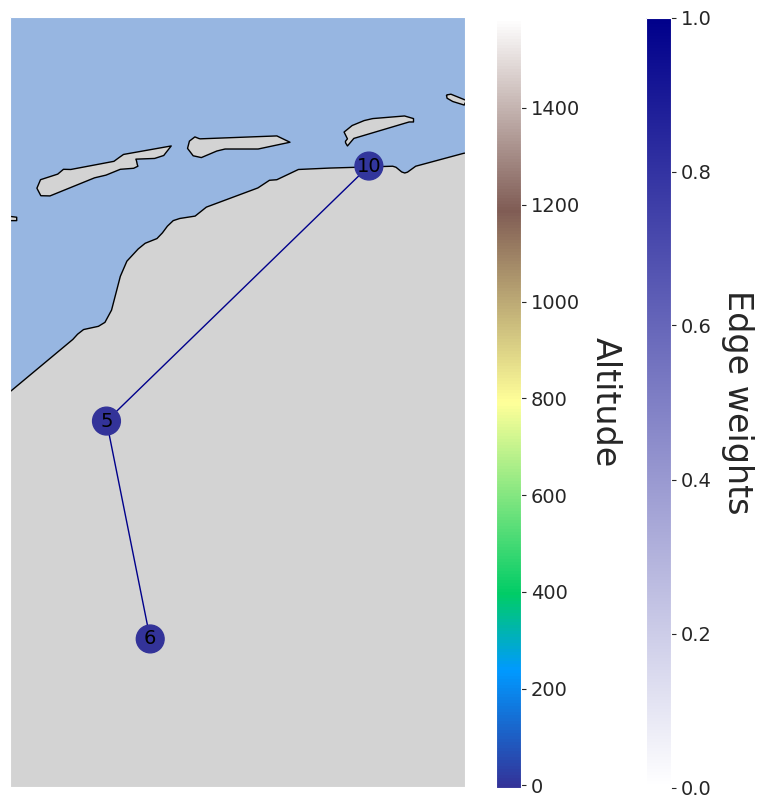

In [251]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import cartopy.crs as ccrs
subG = nx.Graph()

for (u, v), weight in zip (tuples, edge_weights):
    subG.add_edge(u, v, weight=weight)

edges = tuples # list(weights.keys())
# weights = edges # list(weights.values())

fig = plt.figure(figsize=(12, 12))
ax = plot_map()

cmap_alt = cm.terrain
cmap_edge = LinearSegmentedColormap.from_list("white_to_blue", ["white", "darkblue"])

norm_edge = plt.Normalize(0, 1)
norm_alt = plt.Normalize(vmin=min(dataframes['stations']['altitude']), vmax=max(dataframes['stations']['altitude']))
edge_colors = [cmap_edge(norm_edge(w)) for w in edge_weights]
node_colors = [cmap_alt(norm_alt(a)) for a in this_alt_dict.values()]

proj = ccrs.PlateCarree()
margin = 0.3
lon_min, lon_max = min(lons) - margin, max(lons) + margin
lat_min, lat_max = min(lats) - margin, max(lats) + margin

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
# ax.set_extent([2, 8, 50, 54], crs=proj)

sm_nodes = plt.cm.ScalarMappable(cmap=cmap_alt, norm=norm_alt)
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
colbar2 = plt.colorbar(sm_edges, ax=ax, aspect=30, pad=0.04)
colbar1 = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.04)

colbar2.ax.set_ylabel("Edge weights", rotation=270, labelpad=30, fontsize=24)
colbar2.ax.tick_params(labelsize=14)
colbar1.ax.set_ylabel("Altitude", rotation=270, labelpad=30, fontsize=24)
colbar1.ax.tick_params(labelsize=14)

nx.draw_networkx(subG, pos_dict, node_size=400, node_color=node_colors, ax=ax, edge_color=edge_colors, with_labels=False)
nx.draw_networkx_labels(subG, pos_dict, font_size=14)
plt.savefig(os.path.join(FIGUREPATH, f"gnnx_map_{graph_name}_{node_idx}_{leadtime}_{d}.pdf"), format='pdf', dpi=300, bbox_inches='tight')
